In [1]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tqdm
# from tqdm.auto import trange, tqdm
import os

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# to get CFIAR10 dataset
from torchvision import transforms
import torchvision
import torchvision.transforms as transforms

# to import pretrained models
from transformers import AutoImageProcessor, MobileNetV1Model
import timm

# import sklearn
from sklearn.model_selection import train_test_split
from PIL import Image


# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home2/sreenivas88/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from get_layers import get_encoder_layers, get_decoder_layers

---
## Unet architecture

In [5]:
class Unet(nn.Module):
    def __init__(self):
        '''
	        Unet model
        '''
        super(Unet, self).__init__()
        # get encoder layers
        encoder_blocks, image_stem_layer, image_processor = get_encoder_layers()
        # get decoder layers
        decoder_blocks = get_decoder_layers()
        
        # print(len(encoder_blocks))
        # print(len(decoder_blocks))
        
        self.encoder_blocks = encoder_blocks
        self.image_stem_layer = image_stem_layer
        self.image_stem_layer = image_stem_layer
        print("Image stem layer: ", self.image_stem_layer)
        # raise Exception("Stop")
        self.out_image_stem_layer = nn.Sequential(
			nn.ConvTranspose2d(32,3, kernel_size=3, stride=2, bias=False),
			nn.BatchNorm2d(3, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True),
			nn.ReLU()
		)
        print("Out image stem layer: ", self.out_image_stem_layer)
        self.image_processor = image_processor
        
        self.decoder_blocks = decoder_blocks
        
    def forward(self, x, process_image = False):
        '''
	        Forward pass
	        x: input image (ideally should be of shape (batch_size, 3, 224, 224))
			process_image: whether to process image or not to the appropriate size
        '''
        # asset x is a tensor
        assert isinstance(x, torch.Tensor), "Input should be a tensor"
        if process_image:
            new_x = []
            for img in x:
                img = self.image_processor(img)['pixel_values'][0]
                new_x.append(img)
            x = torch.stack(new_x)
            x = x.permute(0, 3, 1, 2)
            
        # assetion to check if the image is of the right size
        assert x.shape[2] == 224 and x.shape[3] == 224, "Image size should be 224x224"
        
        x = self.image_stem_layer(x)
        print("Image stem layer output shape: ", x.shape)
        
        enc_outputs = []
        # run on each encoder block
        for indx, enc_block in enumerate(self.encoder_blocks):
            x = enc_block(x)
            enc_outputs.append(x)
            print(f"Encoder block {indx} | output shape: {x.shape}")
            
        # last encoder block to dec 
        # print input and output shapes
        print("\nLast encoder block output shape: ", x.shape)
        print()
        
        for indx, dec_block in enumerate(self.decoder_blocks):
            if indx == 0:
                x = dec_block(x)
                print(f"Decoder block {indx} | output shape: {x.shape}")
            else:
                x = dec_block(torch.cat([x, enc_outputs[len(self.decoder_blocks) - indx - 1]], dim=1))
                print(f"Decoder block {indx} | output shape: {x.shape}")
        
        return self.out_image_stem_layer(x)

In [6]:
unet = Unet()

# random input
x = torch.randn(1, 3, 224, 224)

# forward pass
y = unet(x)

# print output shape
print(y.shape)

Image stem layer:  MobileNetV1ConvLayer(
  (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (normalization): BatchNorm2d(32, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
  (activation): ReLU6()
)
Out image stem layer:  Sequential(
  (0): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (1): BatchNorm2d(3, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
  (2): ReLU()
)
Image stem layer output shape:  torch.Size([1, 32, 112, 112])
Encoder block 0 | output shape: torch.Size([1, 64, 112, 112])
Encoder block 1 | output shape: torch.Size([1, 128, 56, 56])
Encoder block 2 | output shape: torch.Size([1, 256, 28, 28])
Encoder block 3 | output shape: torch.Size([1, 512, 14, 14])
Encoder block 4 | output shape: torch.Size([1, 1024, 7, 7])

Last encoder block output shape:  torch.Size([1, 1024, 7, 7])



RuntimeError: Given transposed=1, weight of size [512, 256, 3, 3], expected input[1, 1024, 7, 7] to have 512 channels, but got 1024 channels instead

In [ ]:
# now load the model
from utils import load_img_to_tensor
# load images 
input_tensor = load_img_to_tensor("../test/input/")

# print("Input tensor shape: ", input_tensor)

Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])
Loaded image shape: torch.Size([3, 224, 224])


<class 'torch.Tensor'>
Input tensor shape: torch.Size([7, 3, 224, 224])


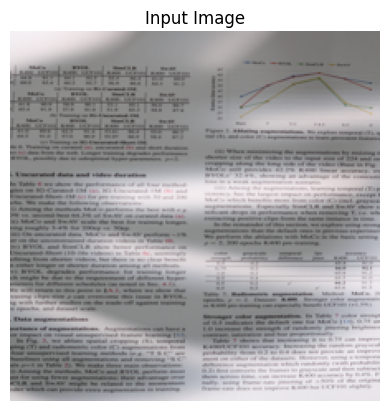

Image stem layer output shape:  torch.Size([7, 32, 112, 112])
Encoder block 0 | output shape: torch.Size([7, 64, 112, 112])
Encoder block 1 | output shape: torch.Size([7, 128, 56, 56])
Encoder block 2 | output shape: torch.Size([7, 256, 28, 28])
Encoder block 3 | output shape: torch.Size([7, 512, 14, 14])
Encoder block 4 | output shape: torch.Size([7, 1024, 7, 7])
Decoder block 0 | output shape: torch.Size([7, 512, 14, 14])
Decoder block 1 | output shape: torch.Size([7, 256, 28, 28])
Decoder block 2 | output shape: torch.Size([7, 128, 56, 56])
Decoder block 3 | output shape: torch.Size([7, 64, 112, 112])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Decoder block 4 | output shape: torch.Size([7, 32, 112, 112])
Output tensor shape: torch.Size([7, 3, 225, 225])


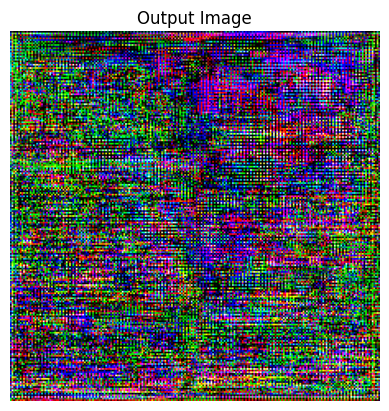

In [ ]:
def visualize_tensor_images(tensor, title="Tensor", cmap=None):
    """
    Visualizes a tensor as an image. shape = (3, H, W)
    """
    tensor_np = tensor.detach().cpu().numpy()  # Convert tensor to numpy array
    plt.imshow(np.transpose(tensor_np, (1, 2, 0)), cmap=cmap)  # Transpose dimensions for imshow
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:

# Print input tensor shape
print(type(input_tensor))
print("Input tensor shape:", input_tensor.shape)

# Visualize the first input image
visualize_tensor(input_tensor[0], title="Input Image")

# Pass input tensor through the UNet model
out_img = unet(input_tensor)

# Print output tensor shape
print("Output tensor shape:", out_img.shape)

# Visualize the output image
visualize_tensor(out_img[0], title="Output Image")

In [ ]:
# # Load an image with path
# image_path = "..\\test\\input\\IMG_0106.png"

# # Load image
# image = Image.open(image_path)

# # Show original image
# plt.imshow(image)
# plt.title("Original Image")
# plt.axis("off")
# plt.show()

# # Preprocess image
# preprocessed_image = image_processor(image)['pixel_values'][0]

# # Transpose the NumPy array
# # preprocessed_image = preprocessed_image.transpose((1, 2, 0))

# print("Preprocessed image shape: ", preprocessed_image.shape)

# # Show preprocessed image
# plt.imshow(preprocessed_image.transpose((1, 2, 0)))
# plt.title("Preprocessed Image")
# plt.axis("off")
# plt.show()